# The Gap Statistic

An alternative to using the elbow method to decide the optimal number of clusters (K) is the Gap statistic. The statistic gives us a way to get an optimal amount of clusters without having to use our eyes.

This method makes use of the within-cluster point scatter. In this case the dissimilarity function is the eucledian distance.

$ W_k = \sum_{k=1}^K\frac{1}{2n_k}D_k $

where 

$ D_k = 2n_k\sum_{x_i\in C_k}||x_i-\mu_k||^2 $

This within-cluster dispersion, $W_k$, is also used in the elbow approach. When finding the gap statistic we compare the $W_k$ found in our sample data, with one from a reference null distribution.

We define the gap statistic as

$ Gap_n(k) = E_n^*(\log(W_k)) - \log(W_k) $

Where $E_n^*$ denotes the expectation under a sample of size n from the reference distribution.

In [7]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import CreateDataFunctions as df

import warnings
warnings.filterwarnings("ignore")

# Same figure size for all figures
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Generate some gaussian clusters
Xdat, Ydat = df.Data_gussian_cluster(nr_data_points=1000)

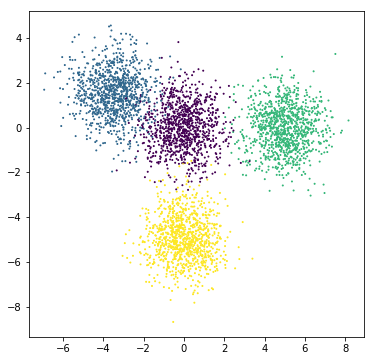

In [8]:
plt.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
plt.show()

### Creating a uniform distrubution inside the boundary of the clusters

In [9]:
def bounding_box(data):
    xMin, yMin = min(data[:,0]), min(data[:,1])
    xMax, yMax = max(data[:,0]), max(data[:,1])
    return xMin,xMax, yMin, yMax

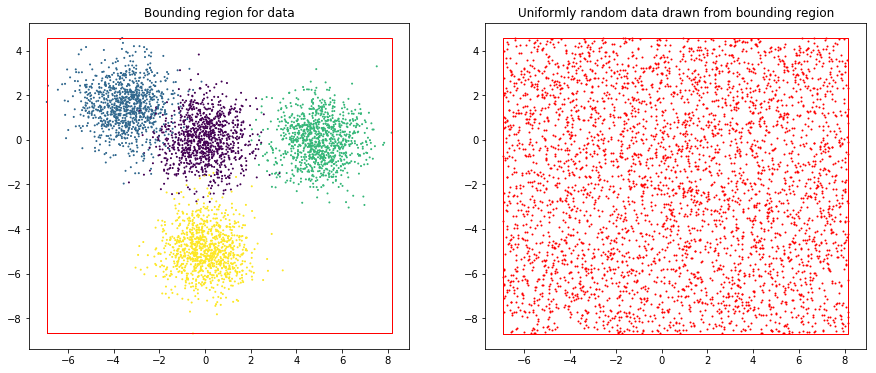

In [10]:
f, (ax1,ax2) = plt.subplots(1, 2)

f.set_figwidth(15)

xMin,xMax,yMin,yMax = bounding_box(Xdat)
ax1.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
ax1.scatter(Xdat[:,0],Xdat[:,1], c=Ydat,s=1) 
ax1.set_title('Bounding region for data')

Random_Xdat = np.transpose(np.array([np.random.uniform(xMin,xMax,int(len(Xdat))), \
                                     np.random.uniform(yMin,yMax,int(len(Xdat)))]))

ax2.plot([xMin, xMin, xMax, xMax, xMin], [yMin, yMax, yMax, yMin, yMin], linewidth=1, c='r')
ax2.scatter(Random_Xdat[:,0],Random_Xdat[:,1], c='r',s=1)
ax2.set_title('Uniformly random data drawn from bounding region')

plt.show()



### Trying out the Kmeans clustering library

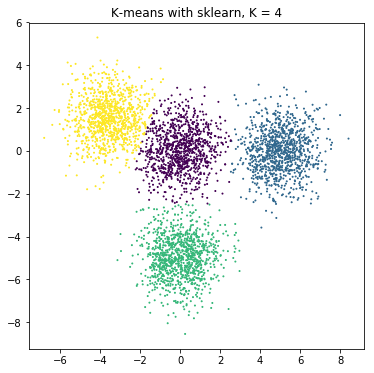

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Xdat)
plt.scatter(Xdat[:,0],Xdat[:,1], c=kmeans.labels_,s=1) 
plt.title("K-means with sklearn, K = 4")
plt.show()

### Plot the within-cluster point scatter for K-means on the real data and uniform data

In [156]:
def bounding_box(data):
    xMin, yMin = min(data[:,0]), min(data[:,1])
    xMax, yMax = max(data[:,0]), max(data[:,1])
    return xMin,xMax, yMin, yMax

def within_cluster_scatter(clusters, mu):
    K = len(mu)
    res = sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) \
               for i in range(K) for c in clusters[i]])
    return res

def get_clusters_from_labels(labels, data, nrClusters):
    return [c for c in [data[labels==i] for i in range(nrClusters)]]

def get_cluster_centers(clusters):
    return [np.mean(c, axis=0).tolist() for c in clusters]

def clustering_algorithm(data, K, algorithm='kmeans'):
    if algorithm == 'kmeans':
        km = KMeans(n_clusters=K, random_state=0).fit(data)
        return km.labels_
    
    if algorithm == 'spectral':
        sc = SpectralClustering(K,eigen_solver='arpack' ,affinity="nearest_neighbors", random_state=0).fit(data)
        return sc.labels_


def get_gap_statistic(data, use_spectral=False, cluster_algorithm='kmeans', K_max=10, verbose=False):
    
    B = 10 # number of reference 
    Ks = range(1,K_max+1) 
    wk_real_data = np.zeros(len(Ks))
    wk_reference_data = np.zeros(len(Ks))
    sdk = np.zeros(len(Ks))
    nrDataPoints = len(data)
    xMin,xMax,yMin,yMax = bounding_box(data)  

    for iK, K in enumerate(Ks):
        
        if verbose:
            print("Calculating for K = {} of {} ...".format(K,K_max))

        # We generate 10 reference data sets with K clusters and check Wk
        wk_bs = np.zeros(B);
        for i in range(B):
            random_Xdat = np.transpose(np.array([np.random.uniform(xMin, xMax, nrDataPoints), \
                                         np.random.uniform(yMin, yMax, nrDataPoints)]))

            km = KMeans(n_clusters=K, random_state=0).fit(random_Xdat)
            clusters_unif = get_clusters_from_labels(km.labels_, random_Xdat, K);
            wk_unif = within_cluster_scatter(clusters_unif, km.cluster_centers_)
            wk_bs[i] = np.log(wk_unif)

        wk_reference_data[iK] = np.mean(wk_bs)

        sdk[iK] = np.sqrt(np.mean((wk_bs - wk_reference_data[iK])**2))

        # Calculate Wk for real data
        km = KMeans(n_clusters=K, random_state=0).fit(data)
        clusters_real = get_clusters_from_labels(km.labels_, data, K);
        wk_real_log = np.log(within_cluster_scatter(clusters_real, km.cluster_centers_))

        wk_real_data[iK] = wk_real_log

    sk = sdk*np.sqrt(1+1/B)
    print(sk)
    
    return wk_real_data, wk_reference_data, sk, Ks

def get_optimal_k(wk, wk_ref, sk, Ks):
    for iK, K in enumerate(Ks):
        if (iK == len(Ks)-1):
            pass
        gap = wk_ref[iK] - wk[iK];
        gap_next = wk_ref[iK+1] - wk[iK+1]
        
        if gap < 0:
            continue
        
        print("Gap(k): {}, Gap(k+1): {}, Sk(k+1): {}".format(gap,gap_next,sk[iK+1]))
        print("Gap(k) - Gap(k+1) - Sk(k+1) = {}".format(gap-gap_next-sk[iK+1]))
        if  (gap >= gap_next - sk[iK+1]):
            return K
        
def plot_wk(Ks, wk, wk_ref):
    f, (ax1,ax2) = plt.subplots(1, 2)
    f.set_figwidth(15)

    ax1.plot(Ks, wk, label=r"$log W_k$")
    ax1.plot(Ks, wk_ref, label=r"$\frac{1}{B}\sum^{B}_{b}\log W_{kb}$")
    ax1.legend(loc='upper right')
    ax1.set_xlabel("K")


    ax2.plot(Ks, np.exp(wk))
    ax2.set_xlabel("K")
    ax2.set_ylabel(r"$W_k$")

    plt.show()
    

In [98]:
# Calculate statistics
wk_real_data, wk_reference_data, sk, Ks = get_gap_statistic(Xdat)

[0.01005501 0.01118451 0.00987475 0.00770007 0.01208805 0.01786519
 0.01059687 0.00890838 0.00577634 0.00923517]


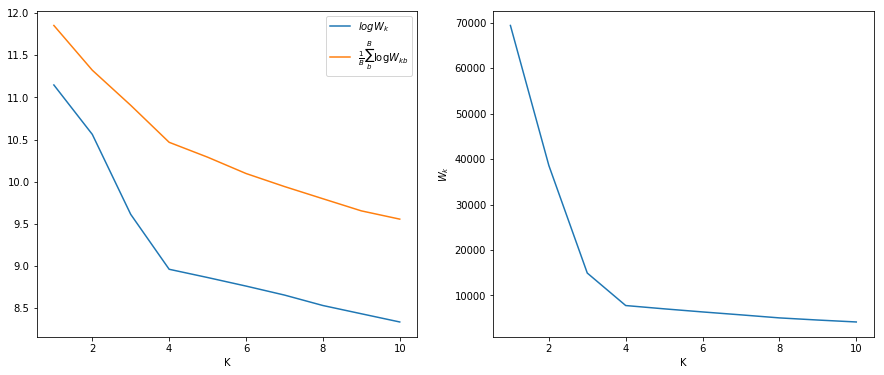

In [99]:
plot_wk(Ks, wk_real_data, wk_reference_data)

We are looking for the smallest $k$ such that $Gap(k) \geq Gap(k+1) - s_{k+1}$

In [100]:
optimal_k = get_optimal_k(wk_real_data, wk_reference_data, sk, Ks)
print("Optimal K {}".format(optimal_k))

Gap(k): 0.7069862092381225, Gap(k+1): 0.7624114965998441, Sk(k+1): 0.011184514706281797
Gap(k) - Gap(k+1) - Sk(k+1) = -0.06660980206800338
Gap(k): 0.7624114965998441, Gap(k+1): 1.2955582533864103, Sk(k+1): 0.00987475201969985
Gap(k) - Gap(k+1) - Sk(k+1) = -0.5430215088062661
Gap(k): 1.2955582533864103, Gap(k+1): 1.5083873814038444, Sk(k+1): 0.0077000665317439225
Gap(k) - Gap(k+1) - Sk(k+1) = -0.22052919454917808
Gap(k): 1.5083873814038444, Gap(k+1): 1.4297943162658147, Sk(k+1): 0.012088051236671045
Gap(k) - Gap(k+1) - Sk(k+1) = 0.06650501390135873
Optimal K 4


The optimal K is calculated to be 3. Using the elbow method, it may be reasonable to come to the same conclusion. It is not correct however and it might have to do with the overlap between the clusters. 

Next we'll try it on a dataset which has greater separation of the clusters.

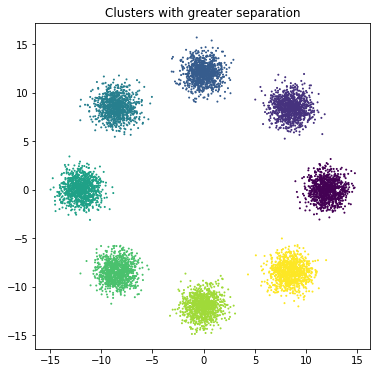

In [32]:
plt.title("Clusters with greater separation")

Xdat_separated, Ydat_separated = df.Data_separated_clusters()
plt.scatter(Xdat_separated[:,0],Xdat_separated[:,1], c=Ydat_separated,s=1) 
plt.show()

In [33]:
wk_separated, wk_ref_separated, sk_sep, Ks_sep = get_gap_statistic(Xdat_separated)

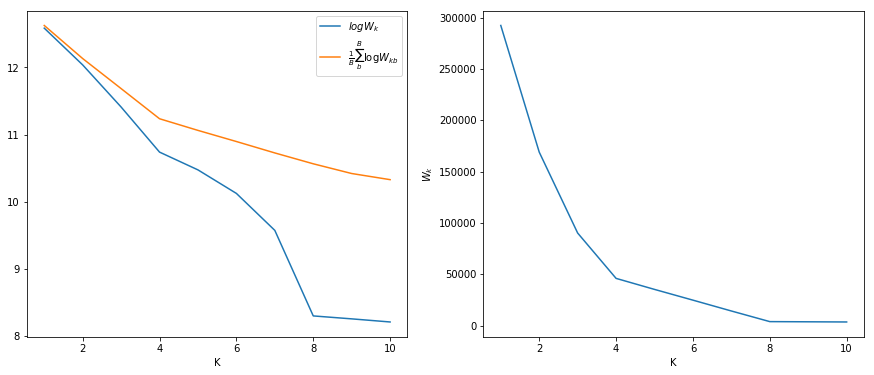

In [34]:
plot_wk(Ks, wk_separated, wk_ref_separated)

In [35]:
optimal_k = get_optimal_k(wk_separated, wk_ref_separated, sk_sep, Ks_sep)
print("Optimal K {}".format(optimal_k))

Optimal K 8


### Let's try for only one cluster

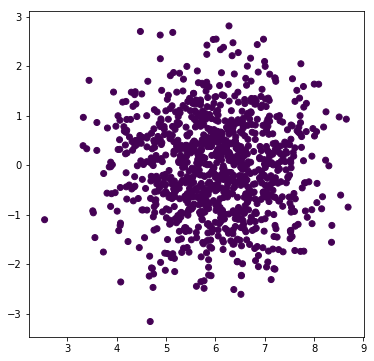

In [17]:
Xdat_one, Ydat_one = df.Data_one_cluster()
plt.scatter(Xdat_one[:,0],Xdat_one[:,1],c=Ydat_one)
plt.show()

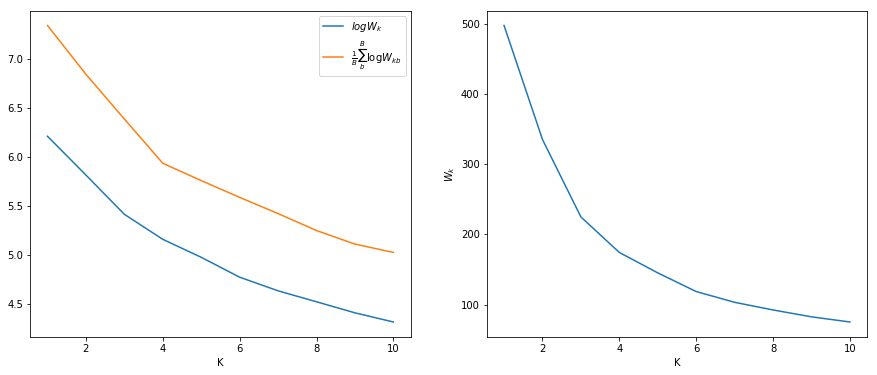

range(1, 11)
range(1, 10)
Optimal K 1


In [18]:
wk_one, wk_ref_one, sk_one, Ks_one = get_gap_statistic(Xdat_one)
plot_wk(Ks, wk_one, wk_ref_one)
ax2.set_ylabel(r"$W_k$")

optimal_k = get_optimal_k(wk_one, wk_ref_one, sk_one, Ks_one)
print("Optimal K {}".format(optimal_k))

plt.show()

### Let's step up our game with some crazy cluster shapes

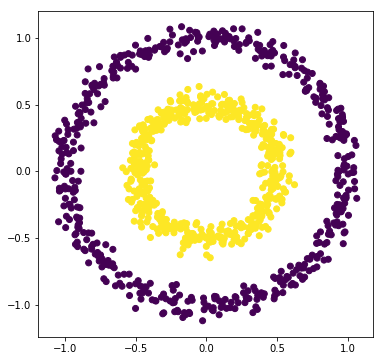

In [19]:
xdat,cs = datasets.make_circles(1000, factor=.5,
                                      noise=.05)
plt.scatter(xdat[:,0],xdat[:,1],c=cs)
plt.show()

### Testing Spectral Clustering for complex clusters

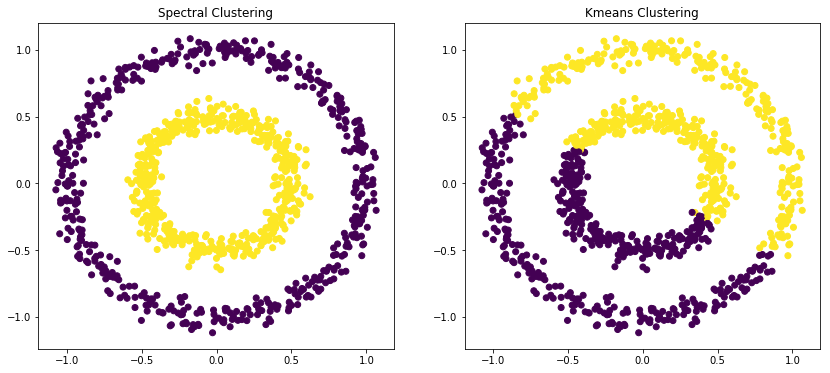

In [20]:
f, (ax1,ax2) = plt.subplots(1, 2)
f.set_figwidth(14)

sc_labels = clustering_algorithm(xdat, K=2, algorithm='spectral')
km_labels = clustering_algorithm(xdat, K=2, algorithm='kmeans')

ax1.scatter(xdat[:,0],xdat[:,1],c=sc_labels)
ax1.set_title('Spectral Clustering')

ax2.scatter(xdat[:,0],xdat[:,1],c=km_labels)
ax2.set_title('Kmeans Clustering')

plt.show()

As we can see, the Kmeans algorithm is not suitable for the circle like data. We'll try out another algorithm called *Spectral Clustering*. Let's create some circular data:

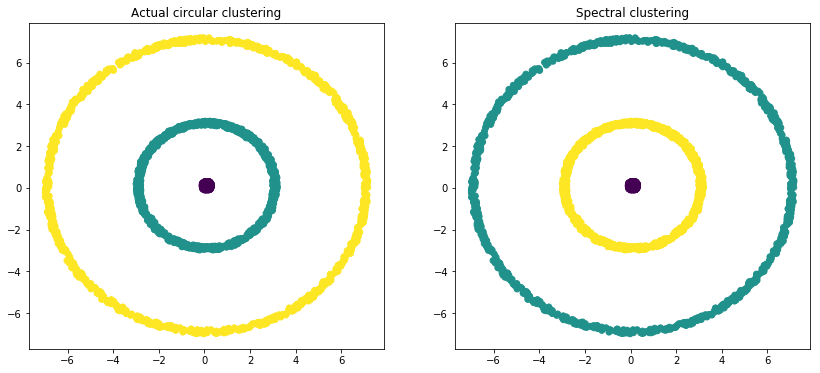

In [21]:
f, (ax1,ax2) = plt.subplots(1, 2)
f.set_figwidth(14)

CircleDat, C = df.ThreeCirclesData()
sc_labels = clustering_algorithm(CircleDat, K=3, algorithm='spectral')

ax1.scatter(CircleDat[:,0], CircleDat[:,1],c=C)
ax1.set_title('Actual circular clustering')

ax2.scatter(CircleDat[:,0], CircleDat[:,1],c=sc_labels)
ax2.set_title('Spectral clustering')

plt.show()

*What in tarnation?*
![wot](https://media.giphy.com/media/3ELtfmA4Apkju/giphy.gif "wot")
Spectral algorithm not clustering the data properly

Xmin: 2.5438081725873873, Xmax: 8.690060078997163, Ymin: -3.1616914255318744, Ymax: 2.8180573318426165


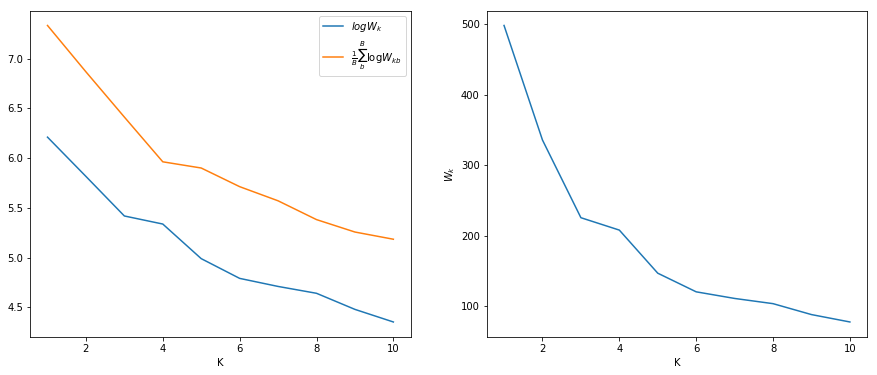

Optimal K 1


In [65]:
wk_circ, wk_circ_ref, sk_circ, Ks_circ = get_gap_statistic(Xdat_one, cluster_algorithm="spectral")
plot_wk(Ks_circ, wk_circ, wk_circ_ref)

optimal_k = get_optimal_k(wk_circ, wk_circ_ref, sk_circ, Ks_circ)
print("Optimal K {}".format(optimal_k))

plt.show()

This actually does not seem to work very well for the gap statistic algorithm. Looking at the 'elbow', it seems as 3-4 clusters would be reasonable. This could caused by the wrong clustering made by our spectral algorithm.

## Large N

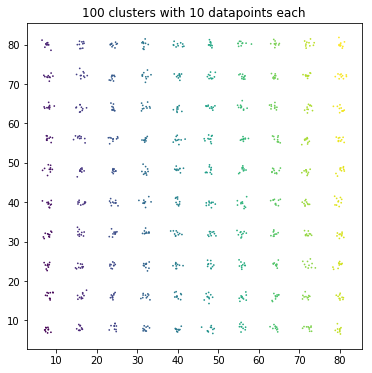

In [172]:
gz = 10
ndp = 10

Xdat_large, Ydat_large = df.Gaussian_cluster_grid(grid_size=gz, scale=8, nr_data_points=ndp, sigma=0.6)
plt.scatter(Xdat_large[:,0],Xdat_large[:,1],s=0.5, c=Ydat_large)
plt.title("{} clusters with {} datapoints each".format(gz**2, ndp))
plt.show()

In [173]:
wk_large, wk_large_ref, sk_large, Ks_large = get_gap_statistic(Xdat_large, cluster_algorithm="kmeans", \
                                                               K_max=110,verbose=True)

Calculating for K = 1 of 110 ...
Calculating for K = 2 of 110 ...
Calculating for K = 3 of 110 ...
Calculating for K = 4 of 110 ...
Calculating for K = 5 of 110 ...
Calculating for K = 6 of 110 ...
Calculating for K = 7 of 110 ...
Calculating for K = 8 of 110 ...
Calculating for K = 9 of 110 ...
Calculating for K = 10 of 110 ...
Calculating for K = 11 of 110 ...
Calculating for K = 12 of 110 ...
Calculating for K = 13 of 110 ...
Calculating for K = 14 of 110 ...
Calculating for K = 15 of 110 ...
Calculating for K = 16 of 110 ...
Calculating for K = 17 of 110 ...
Calculating for K = 18 of 110 ...
Calculating for K = 19 of 110 ...
Calculating for K = 20 of 110 ...
Calculating for K = 21 of 110 ...
Calculating for K = 22 of 110 ...
Calculating for K = 23 of 110 ...
Calculating for K = 24 of 110 ...
Calculating for K = 25 of 110 ...
Calculating for K = 26 of 110 ...
Calculating for K = 27 of 110 ...
Calculating for K = 28 of 110 ...
Calculating for K = 29 of 110 ...
Calculating for K = 30 

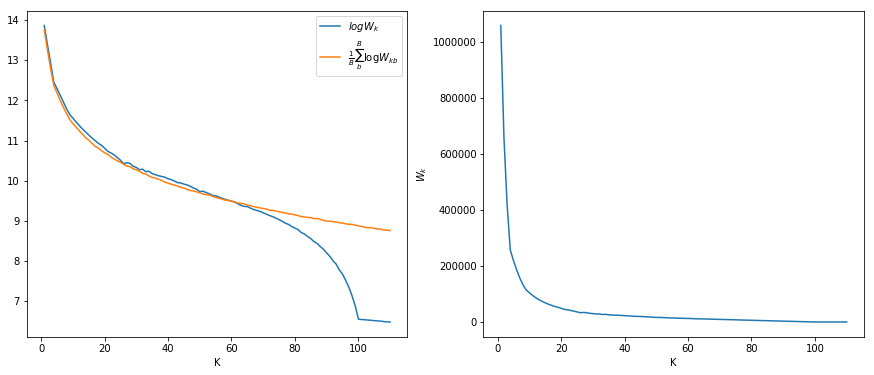

Gap(k): 0.021561605571202236, Gap(k+1): 0.04937169805650754, Sk(k+1): 0.02134636045906057
Gap(k) - Gap(k+1) - Sk(k+1) = -0.049156452944365873
Gap(k): 0.04937169805650754, Gap(k+1): 0.06495234501955949, Sk(k+1): 0.018917042952453784
Gap(k) - Gap(k+1) - Sk(k+1) = -0.03449768991550573
Optimal K 63


In [175]:
plot_wk(Ks_large, wk_large, wk_large_ref)
plt.show()
optimal_k = get_optimal_k(wk_large, wk_large_ref, sk_large, Ks_large)
print("Optimal K {}".format(optimal_k))

Something's up with the algorithm, it should make a better decision :/

## Large P
We'll begin by looking at one more dimension:

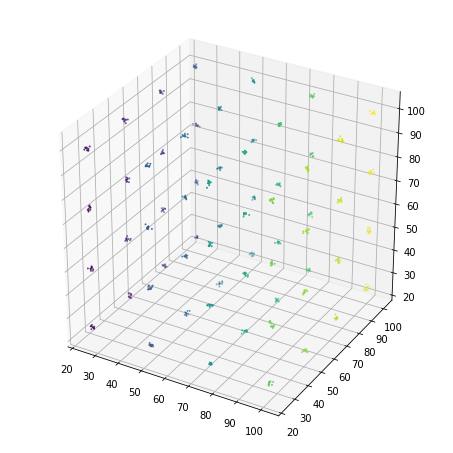

In [14]:
from mpl_toolkits.mplot3d import Axes3D
Xdat_large_3d, Ydat_large_3d = df.Gaussian_cluster_grid(grid_size=4, scale=25, nr_data_points=10, nr_features=3, sigma=0.5)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(Xdat_large_3d[:,0], Xdat_large_3d[:,1], Xdat_large_3d[:,2], c=Ydat_large_3d, s=1)
plt.show()



Calculating for K = 1 of 75 ...
Calculating for K = 2 of 75 ...
Calculating for K = 3 of 75 ...
Calculating for K = 4 of 75 ...
Calculating for K = 5 of 75 ...
Calculating for K = 6 of 75 ...
Calculating for K = 7 of 75 ...
Calculating for K = 8 of 75 ...
Calculating for K = 9 of 75 ...
Calculating for K = 10 of 75 ...
Calculating for K = 11 of 75 ...
Calculating for K = 12 of 75 ...
Calculating for K = 13 of 75 ...
Calculating for K = 14 of 75 ...
Calculating for K = 15 of 75 ...
Calculating for K = 16 of 75 ...
Calculating for K = 17 of 75 ...
Calculating for K = 18 of 75 ...
Calculating for K = 19 of 75 ...
Calculating for K = 20 of 75 ...
Calculating for K = 21 of 75 ...
Calculating for K = 22 of 75 ...
Calculating for K = 23 of 75 ...
Calculating for K = 24 of 75 ...
Calculating for K = 25 of 75 ...
Calculating for K = 26 of 75 ...
Calculating for K = 27 of 75 ...
Calculating for K = 28 of 75 ...
Calculating for K = 29 of 75 ...
Calculating for K = 30 of 75 ...
Calculating for K =

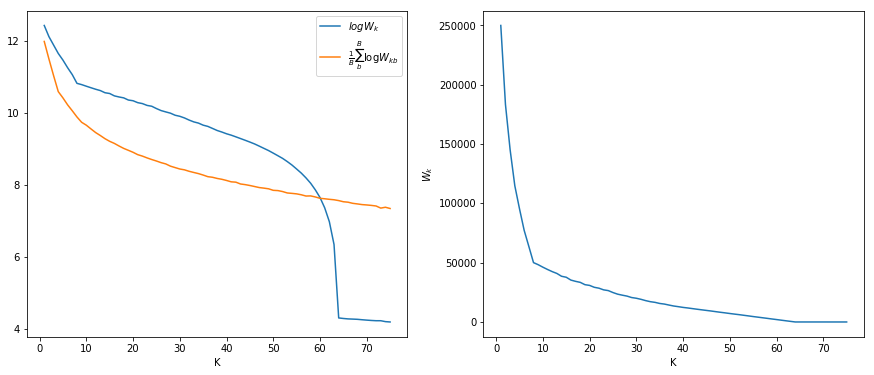

Optimal K 11


In [24]:
wk_large_3d, wk_large_ref_3d, sk_large_3d, Ks_large_3d = get_gap_statistic(Xdat_large_3d, cluster_algorithm="kmeans", \
                                                               K_max=75,verbose=True)
plot_wk(Ks_large_3d, wk_large_3d, wk_large_ref_3d)
plt.show()
optimal_k = get_optimal_k(wk_large_3d, wk_large_ref_3d, sk_large_3d, Ks_large_3d)
print("Optimal K {}".format(optimal_k))

The method for picking K seems to be broken, I probably programmed it wrong. But it actually looks pretty good in comparison with the elbow method. one can se a point where the $\log{W_k}$ tampers off (around 64 which is the correct number of clusters)

### Circular Data Structure

It might have something to do with the structure of the grid. If the clusters themselves is positioned uniformly in a square, it might cause the gap statistic to not really work. Let's try circular data

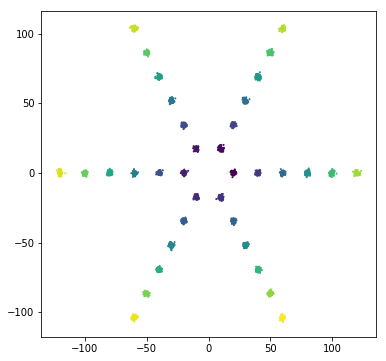

In [165]:
Xdat_large_circ, Y_dat_large_circ = df.create_rings_of_clusters(nr_rings=6, classes_per_ring=6, \
                                                                radius=20, points_per_cluster=100)
plt.scatter(Xdat_large_circ[:,0], Xdat_large_circ[:,1], c=Y_dat_large_circ, s=1)
plt.show()

In [166]:
wk_large_circ, wk_large_ref_circ, sk_large_circ, Ks_large_circ = get_gap_statistic(Xdat_large_circ, cluster_algorithm="kmeans", \
                                                               K_max=12,verbose=True)


Calculating for K = 1 of 12 ...
Calculating for K = 2 of 12 ...
Calculating for K = 3 of 12 ...
Calculating for K = 4 of 12 ...
Calculating for K = 5 of 12 ...
Calculating for K = 6 of 12 ...
Calculating for K = 7 of 12 ...
Calculating for K = 8 of 12 ...
Calculating for K = 9 of 12 ...
Calculating for K = 10 of 12 ...
Calculating for K = 11 of 12 ...
Calculating for K = 12 of 12 ...
[0.01346772 0.0111324  0.00895202 0.01093195 0.00703275 0.01386641
 0.01145548 0.00797189 0.00667501 0.00879434 0.01102138 0.01006526]


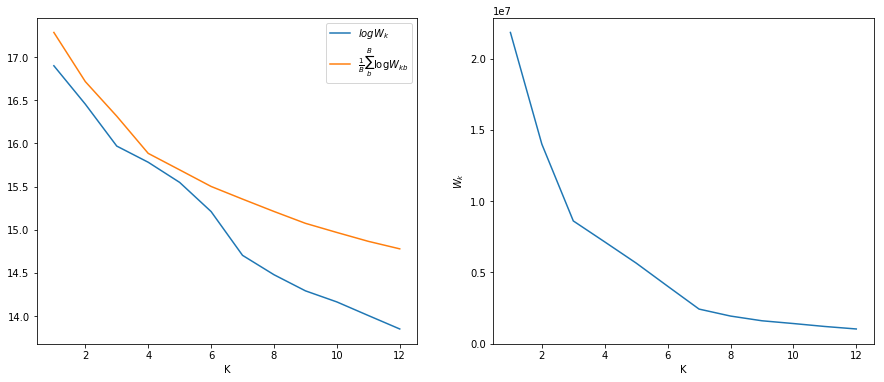

Gap(k): 0.38556446367100605, Gap(k+1): 0.2612175566972397, Sk(k+1): 0.011132404017138858
Gap(k) - Gap(k+1) - Sk(k+1) = 0.11321450295662752
Optimal K 1


In [167]:
plot_wk(Ks_large_circ, wk_large_circ, wk_large_ref_circ)
plt.show()
optimal_k = get_optimal_k(wk_large_circ, wk_large_ref_circ, sk_large_circ, Ks_large_circ)
print("Optimal K {}".format(optimal_k))